In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from six.moves import cPickle as pickle
from six.moves import range
import time

In [2]:
pickle_file = 'SVHN_1x64x64_train.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    del save  # hint to help gc free up memory
    print('train set', train_dataset.shape, train_labels.shape)

train set (97722, 1, 64, 64) (97722, 6)


In [3]:
pickle_file = 'SVHN_1x64x64_valid.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    del save  # hint to help gc free up memory
    print('valid set', valid_dataset.shape, valid_labels.shape)

valid set (5679, 1, 64, 64) (5679, 6)


In [4]:
c4 = []

for i in range(97722):
    categ = train_labels[i][0]
    if(categ == 4):
        c4.append(i)

print(len(c4))

6227


In [5]:
c4_val = []

for j in range(5679):
    categ = valid_labels[j][0]
    if(categ == 4):
        c4_val.append(j)

print(len(c4_val))

159


In [6]:
c4_data = train_dataset[c4]
c4_target = train_labels[c4]
print(c4_data.shape)
print(c4_target.shape)

(6227, 1, 64, 64)
(6227, 6)


In [7]:
c4_data_val = valid_dataset[c4_val]
c4_target_val = valid_labels[c4_val]
print(c4_data_val.shape)
print(c4_target_val.shape)

(159, 1, 64, 64)
(159, 6)


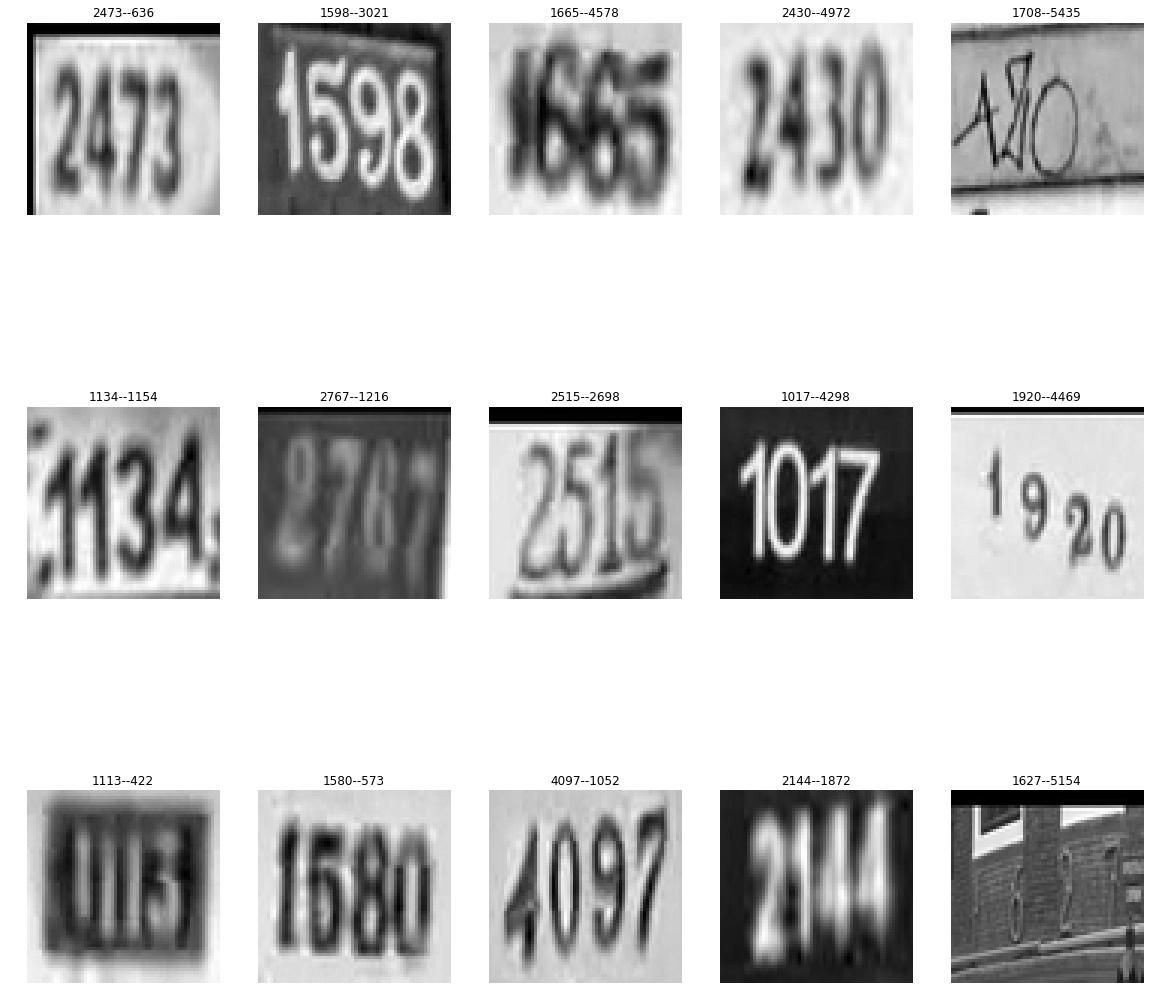

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=3, ncols=5)

im_samples = []

for row in range(3):
    for i, j in enumerate(np.sort(np.random.randint(0, c4_target.shape[0], size=5))):
        im = c4_data[j].reshape((64, 64, 1))
        house_num = ''
        for k in np.arange(c4_target[j,0]):
            house_num += str(c4_target[j,k+1])
        house_num += "--" + str(j)
        im_samples.extend([j])
        ax[row, i].axis('off')
        ax[row, i].set_title(house_num, loc='center')
        ax[row, i].imshow(im[:,:,0], cmap='gray')

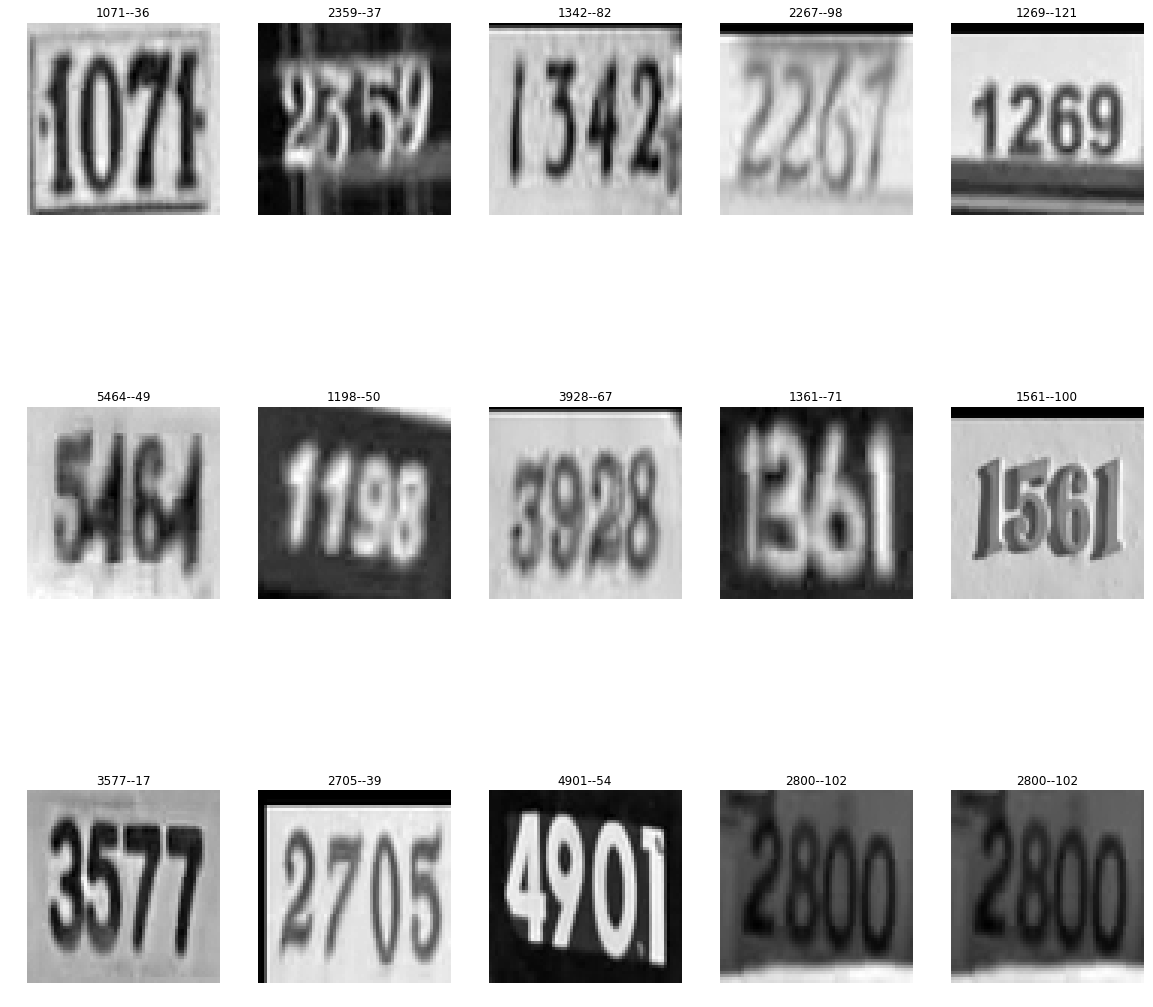

In [9]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=3, ncols=5)

im_samples = []

for row in range(3):
    for i, j in enumerate(np.sort(np.random.randint(0, c4_target_val.shape[0], size=5))):
        im = c4_data_val[j].reshape((64, 64, 1))
        house_num = ''
        for k in np.arange(c4_target_val[j,0]):
            house_num += str(c4_target_val[j,k+1])
        house_num += "--" + str(j)
        im_samples.extend([j])
        ax[row, i].axis('off')
        ax[row, i].set_title(house_num, loc='center')
        ax[row, i].imshow(im[:,:,0], cmap='gray')

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 3, padding=(1, 1))
        self.conv2 = nn.Conv2d(20, 40, 3, padding=(1, 1))
        self.conv3 = nn.Conv2d(40, 80, 3, padding=(1, 1))
        self.conv4 = nn.Conv2d(80, 120, 3, padding=(1, 1))
        self.conv5 = nn.Conv2d(120, 160, 3, padding=(1, 1))
        self.conv6 = nn.Conv2d(160, 200, 3, padding=(1, 1))
        self.conv7 = nn.Conv2d(200, 240, 3, padding=(1, 1))
        self.pool = nn.MaxPool2d(2, 2)
        self.drop2d = nn.Dropout2d(0.25)
        self.drop1 = nn.Dropout(0.35)
        self.drop2 = nn.Dropout(0.5)
        self.bnorm1 = nn.BatchNorm2d(80)
        self.bnorm2 = nn.BatchNorm2d(120)
        self.bnorm3 = nn.BatchNorm2d(160)
        self.bnorm4 = nn.BatchNorm2d(200)
        self.bnorm5 = nn.BatchNorm2d(240)
        self.FC = nn.Linear(960, 1080)
        self.digitlength = nn.Linear(1080, 7)
        self.digit1 = nn.Linear(1080, 10)
        self.digit2 = nn.Linear(1080, 10)
        self.digit3 = nn.Linear(1080, 10)
        self.digit4 = nn.Linear(1080, 10)
        self.digit5 = nn.Linear(1080, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.drop2d(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.drop2d(x)
        x = self.bnorm1(F.relu(self.conv3(x)))
        x = self.pool(self.bnorm2(F.relu(self.conv4(x))))
        x = self.drop1(x)
        x = self.pool(self.bnorm3(F.relu(self.conv5(x))))
        x = self.drop1(x)
        x = self.pool(self.bnorm4(F.relu(self.conv6(x))))
        x = self.drop1(x)
        x = self.pool(self.bnorm5(F.relu(self.conv7(x))))
        x = x.view(-1, 960)
        x = self.drop1(x)
        x = F.relu(self.FC(x))
        x = self.drop2(x)
        yl = self.digitlength(x)
        y1 = self.digit1(x)
        y2 = self.digit2(x)
        y3 = self.digit3(x)
        y4 = self.digit4(x)
        y5 = self.digit5(x)
        return [yl, y1, y2, y3, y4, y5]

In [11]:
net = Net()
f = open('c5.pkl', 'rb')
net.load_state_dict(torch.load(f))
f.close()
net.cuda()

Net (
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(80, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(120, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(160, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(200, 240, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (drop2d): Dropout2d (p=0.25)
  (drop1): Dropout (p = 0.35)
  (drop2): Dropout (p = 0.5)
  (bnorm1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True)
  (bnorm2): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True)
  (bnorm3): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True)
  (bnorm4): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True)
  (bnorm5): BatchNorm2d(24

In [12]:
c4_data_tensor = torch.from_numpy(c4_data)
c4_target_tensor = torch.from_numpy(c4_target).type(torch.LongTensor)
print(c4_data_tensor.type(), c4_data_tensor.size())
print(c4_target_tensor.type(), c4_target_tensor.size())

torch.FloatTensor torch.Size([6227, 1, 64, 64])
torch.LongTensor torch.Size([6227, 6])


In [13]:
c4_data_tensor_val = torch.from_numpy(c4_data_val)
c4_target_tensor_val = torch.from_numpy(c4_target_val).type(torch.LongTensor)
print(c4_data_tensor_val.type(), c4_data_tensor_val.size())
print(c4_target_tensor_val.type(), c4_target_tensor_val.size())

torch.FloatTensor torch.Size([159, 1, 64, 64])
torch.LongTensor torch.Size([159, 6])


In [14]:
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [15]:
num_epochs = 20
batch_size = 64
num_train =  c4_data.shape[0]
num_valid = c4_data_val.shape[0]
iter_per_epoch_tr = num_train // batch_size
iter_per_epoch_val = num_valid // batch_size
print_every_tr = 60
print_every_val = 2
print(iter_per_epoch_tr)
print(iter_per_epoch_val)

97
2


In [16]:
tr_epoch_losses = {i:[] for i in range(num_epochs)}
tr_loss_history = []
val_epoch_losses = {i:[] for i in range(num_epochs)}
val_loss_history = []

In [17]:
for epoch in range(num_epochs):  # loop over the dataset multiple times
    
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 110)
    
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        
        if phase == 'train':
            net.train(True)  # Set model to training mode
            print("train phase")
            i = 0
            rng_state = torch.get_rng_state()
            new_idxs = torch.randperm(num_train)
            c4_X = c4_data_tensor[new_idxs]
            c4_Y = c4_target_tensor[new_idxs]
            iter_per_epoch = iter_per_epoch_tr
            print_every = print_every_tr
        else:
            net.train(False)  # Set model to evaluate mode
            print("evaluate phase")
            i = 0
            rng_state = torch.get_rng_state()
            new_idxs = torch.randperm(num_valid)
            c4_X = c4_data_tensor_val[new_idxs]
            c4_Y = c4_target_tensor_val[new_idxs]
            iter_per_epoch = iter_per_epoch_val
            print_every = print_every_val

        t1 = time.time()
        for t in range(iter_per_epoch):
            X_batch = c4_X[i: i+batch_size]
            Y_batch = c4_Y[i: i+batch_size]
            i += batch_size

            Y_batch = Variable(Y_batch.cuda())
            X_batch = Variable(X_batch.cuda())
            #Y_batch = Variable(Y_batch)
            #X_batch = Variable(X_batch)

            optimizer.zero_grad()

            outputs = net(X_batch)

            lossl = objective(outputs[0], Y_batch[:, 0])
            loss1 = objective(outputs[1], Y_batch[:, 1])
            loss2 = objective(outputs[2], Y_batch[:, 2])
            loss3 = objective(outputs[3], Y_batch[:, 3])
            loss4 = objective(outputs[4], Y_batch[:, 4])
            #loss5 = objective(outputs[5], Y_batch[:, 5])
            final_loss = lossl + loss1 + loss2 + loss3 + loss4
            
            if phase == 'train':
                final_loss.backward()
                optimizer.step()
                tr_loss_history.append(final_loss.data[0])
                tr_epoch_losses[epoch].append(final_loss.data[0])
            else:
                val_loss_history.append(final_loss.data[0])
                val_epoch_losses[epoch].append(final_loss.data[0])
   
            if (t % print_every == 0):
                print('Iteration : ', t+1, ' / ', iter_per_epoch)
                print('loss : ', final_loss.data[0])
                print('lossl : ', lossl.data[0], 'loss1 : ', loss1.data[0], 'loss2 : ', loss2.data[0], 'loss3 : ', loss3.data[0])
                print('loss4 : ', loss4.data[0])
        t2 = time.time()
        print("time taken : ", t2-t1)
        print('-' * 110)


Epoch 0/19
--------------------------------------------------------------------------------------------------------------
train phase
Iteration :  1  /  97
loss :  55.43372344970703
lossl :  24.333772659301758 loss1 :  5.462127685546875 loss2 :  7.622984409332275 loss3 :  9.03563117980957
loss4 :  8.979208946228027
Iteration :  61  /  97
loss :  8.240893363952637
lossl :  0.07589834928512573 loss1 :  1.1425186395645142 loss2 :  2.3618083000183105 loss3 :  2.3699698448181152
loss4 :  2.290698289871216
time taken :  151.54585099220276
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  2
loss :  8.369678497314453
lossl :  0.027089890092611313 loss1 :  1.7536942958831787 loss2 :  2.197176218032837 loss3 :  2.168215751647949
loss4 :  2.2235021591186523
time taken :  1.1990385055541992
--------------------------------------------------------------------------------------------------------------
Epoc

loss4 :  1.1212462186813354
Iteration :  61  /  97
loss :  4.293152809143066
lossl :  0.00038358569145202637 loss1 :  0.5934885144233704 loss2 :  1.194040060043335 loss3 :  1.1778841018676758
loss4 :  1.3273563385009766
time taken :  165.50367999076843
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  2
loss :  3.935894250869751
lossl :  2.4508684873580933e-05 loss1 :  1.3029234409332275 loss2 :  1.0243849754333496 loss3 :  0.8253818154335022
loss4 :  0.7831794619560242
time taken :  1.1569530963897705
--------------------------------------------------------------------------------------------------------------
Epoch 9/19
--------------------------------------------------------------------------------------------------------------
train phase
Iteration :  1  /  97
loss :  4.121510028839111
lossl :  5.706772208213806e-05 loss1 :  0.30378228425979614 loss2 :  1.2111378908157349 loss3 :  1.21360

time taken :  117.30895066261292
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  2
loss :  2.1221327781677246
lossl :  0.0006055161356925964 loss1 :  1.083112120628357 loss2 :  0.2566189467906952 loss3 :  0.43506142497062683
loss4 :  0.346734881401062
time taken :  0.49924206733703613
--------------------------------------------------------------------------------------------------------------
Epoch 17/19
--------------------------------------------------------------------------------------------------------------
train phase
Iteration :  1  /  97
loss :  1.6897070407867432
lossl :  0.000557679682970047 loss1 :  0.18942156434059143 loss2 :  0.33506086468696594 loss3 :  0.5586897730827332
loss4 :  0.6059772372245789
Iteration :  61  /  97
loss :  1.5720717906951904
lossl :  2.1532177925109863e-06 loss1 :  0.10716071724891663 loss2 :  0.4581289291381836 loss3 :  0.37766680121421814
loss4 :  0

In [18]:
f = open("c5-c4.pkl", "bw")
torch.save(net.state_dict(), f)
f.close()

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

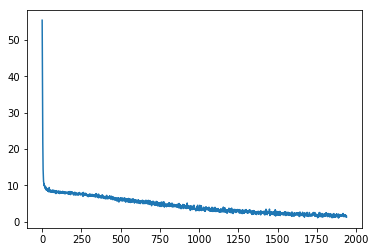

In [21]:
plt.figure()
plt.plot(tr_loss_history)